# EXPLORATION 11 : 폐렴아 기다려라!

## 준비한 데이터
- 캐글의 Chest X-Ray Images

## 1. 실험환경 Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1080
Pneumonia images count in training set: 3105


tf.data 인스턴스를 만들어 봅시다.  
tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/data/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


현재 이미지에는 라벨 데이터가 따로 없습니다.  
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에  
이를 이용해서 라벨 데이터를 만들어 주는 get_label 함수를 만들어 보겠습니다.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):                 # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [12]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

**prepare_for_training()** 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

**shuffle()** 을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

**repeat()** 를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데  
이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.  
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

**batch()** 를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.  
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

**prefetch()** 를 사용하면 학습 데이터를 나눠서 읽어오기 때문에  
첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

## 3. 데이터 시각화

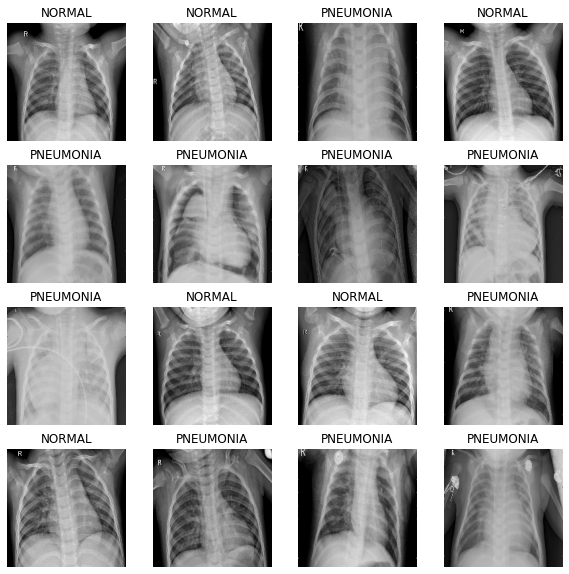

In [14]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [17]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


## 6. 모델 훈련

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adagrad',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [19]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 138ms/step - loss: 0.6938 - accuracy: 0.6341 - precision: 0.8617 - recall: 0.6017 - val_loss: 0.6394 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 131ms/step - loss: 0.4225 - accuracy: 0.7702 - precision: 0.9667 - recall: 0.7139 - val_loss: 0.5794 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 132ms/step - loss: 0.3578 - accuracy: 0.8210 - precision: 0.9747 - recall: 0.7775 - val_loss: 0.3352 - val_accuracy: 0.8346 - val_precision: 0.8191 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 34s 132ms/step - loss: 0.3199 - accuracy: 0.8328 - precision: 0.9747 - recall: 0.7976 - val_loss: 0.1687 - val_accuracy: 0.9500 - val_precision: 0.9605 - val_recall: 0.9729
Epoch 5/25
261/261 [==============================] - 35s 132ms/step - loss: 0.2940 - accura

## 7. 결과확인

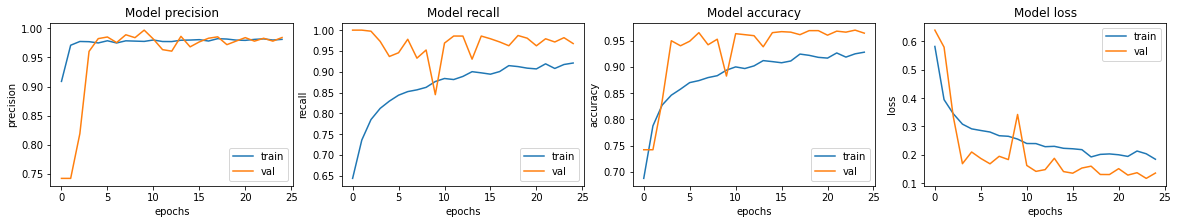

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 73ms/step - loss: 0.4724 - accuracy: 0.7965 - precision: 0.7594 - recall: 0.9872


## 8. 옵티마이저 변경해보기

In [25]:
with tf.device('/GPU:0'):
    model1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 49s 151ms/step - loss: 0.4585 - accuracy: 0.7710 - precision: 0.9356 - recall: 0.7376 - val_loss: 0.7003 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 38s 146ms/step - loss: 0.2465 - accuracy: 0.8987 - precision: 0.9692 - recall: 0.8916 - val_loss: 1.1790 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 38s 146ms/step - loss: 0.2054 - accuracy: 0.9210 - precision: 0.9750 - recall: 0.9175 - val_loss: 0.4721 - val_accuracy: 0.7837 - val_precision: 0.7745 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 38s 146ms/step - loss: 0.1540 - accuracy: 0.9444 - precision: 0.9820 - recall: 0.9421 - val_loss: 0.1800 - val_accuracy: 0.9250 - val_precision: 0.9085 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 38s 146ms/step - loss: 0.1517 - accura

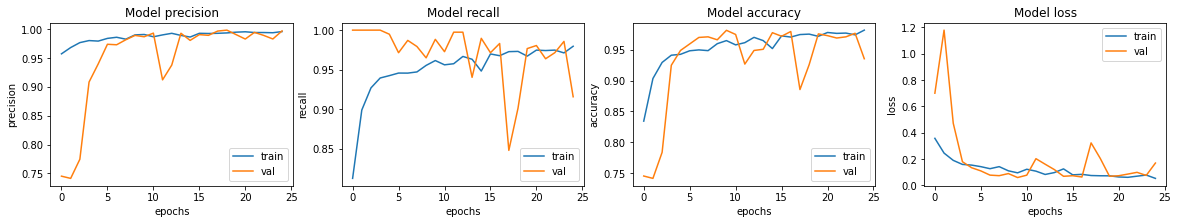

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, acc, prec, rec = model1.evaluate(test_ds)

39/39 [==============================] - 3s 73ms/step - loss: 0.5749 - accuracy: 0.8718 - precision: 0.8523 - recall: 0.9615


Accuracy 기준 85% 이상에 도달하였다.

# 프로젝트 결과

변경해볼 수 있는 요소가 Batch size, Epoch, optimizer 등 있었는데  
Batch size는 32보다 16일때 더 정확도가 좋았고 Epoch 은 25가 적당한 것 같아서 변경하지 않았다.  
optimizer에 따라 결과가 어떻게 바뀌는지 궁금해서 중점적으로 실험해보았는데 결과는  

Adam  
loss: 0.6108 - accuracy: 0.8542 - precision: 0.8360 - recall: 0.9538  
Adadelta  
loss: 0.3691 - accuracy: 0.8381 - precision: 0.8981 - recall: 0.8359  
Adamax  
loss: 1.0907 - accuracy: 0.7324 - precision: 0.7009 - recall: 0.9974  
Adagrad  
loss: 0.4724 - accuracy: 0.7965 - precision: 0.7594 - recall: 0.9872  
두번째 Adam  
loss: 0.5749 - accuracy: 0.8718 - precision: 0.8523 - recall: 0.9615  

최종적으로 맨 처음 Adam을 옵티마이저로 사용했을때와 두번째로 다시 Adam을 옵티마이저로 사용했을때가 accuracy는 제일 높았다.  
근데 의료 영상 모델의 특성상 진짜 환자를 환자라고 판단하는 recall 값이 중요한데 그것이 가장 높은게 Adamax여서  
안전성은 높다는 생각이 들기는 하지만 기본적으로 accuracy가 너무 낮아서 환자가 아닌사람을 환자로 판단하거나  
환자인사람을 환자가 아니라고 판단하는 등 정확도가 좋지 않기 때문에 옵티마이저로 사용은 불가능하다고 생각했다.  

추가적으로 loss 함수를 변경해보고 Dropout 레이어를 제거해보고 BatchNormalization 레이어도 제거해보았는데 결과는 accuracy가 좋지않았고  
마지막으로 augmentation을 적용해보았는데 결과는  
loss: 0.8474 - accuracy: 0.7901 - precision: 0.7495 - recall: 0.9974  
역시 좋지 못했다.  

90퍼센트를 넘는 accuracy와 recall 값을 찍는것이 목표였는데 매우 힘든 목표라는걸 깨달았다.